## Decsion trees

In [177]:
import numpy as np
import pandas as pd
import data_preprocess as dp

In [178]:
data = pd.read_csv('./data/D2.csv')

### Steps to preprocess the data

- Revisit the data pre-processing steps from assignment 1
- Drop the columns with missing values - A1Cresult and max_glu_serum
- Reduce the number of unique values in the medical_specialty column, the admission_type_id column, the discharge_disposition_id column, and the admission_source_id column
- Convert the categorical columns into numerical columns using encoding
- Split the data into training and testing sets


In [179]:
# pandas set decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [180]:
df = dp.data_prep(data, verbose=True)

Running drop_columns_with_missing_values...
Running recode_medical_specialty...
Running recode_admission_type...
Running recode_discharge_disposition...
Running recode_admission_source...
Running recode_binary_values...
Running recode_drug_columns...
Running recode_age_column...
Running drop_deceased_patients...
Data preparation complete.


In [181]:
df_copy = df.copy()

In [182]:
# use one-hot encoding for race, medical_specialty, admission_type, discharge_disposition, admission_source
df = pd.get_dummies(df, columns=['race', 'medical_specialty', 'admission_type', 'discharge_disposition', 'admission_source'], dtype=int)

In [183]:
df.readmitted.value_counts(normalize=True)

readmitted
0   0.526
1   0.474
Name: proportion, dtype: float64

In [184]:
y = df['readmitted']

In [185]:
X = df.drop('readmitted', axis=1)

In [186]:
from sklearn.model_selection import train_test_split

In [187]:
rs = 1

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

In [189]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [190]:
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [191]:
model.get_params(deep=True)

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1,
 'splitter': 'best'}

In [192]:
print(f'Training accuracy: {accuracy_score(y_train, model.predict(X_train)):.3f}')

Training accuracy: 1.000


In [193]:
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test)):.3f}')

Test accuracy: 0.565


In [194]:
num_nodes = model.tree_.node_count
num_leaves = model.tree_.n_leaves

print(f'Total number of nodes: {num_nodes}')
print(f'Total number of leaves (rules): {num_leaves}')

Total number of nodes: 9017
Total number of leaves (rules): 4509


In [195]:
features = X.columns
# Get the feature index for the first split
first_split_feature_index = model.tree_.feature[0]

# Get the feature name by using the index
first_split_feature_name = features[first_split_feature_index]  

print(f'The first split is made on the feature: {first_split_feature_name}')

The first split is made on the feature: number_inpatient


In [196]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59      2051
           1       0.55      0.54      0.54      1885

    accuracy                           0.56      3936
   macro avg       0.56      0.56      0.56      3936
weighted avg       0.56      0.56      0.56      3936



In [233]:
feature_names = X.columns  # Names of the features
importances = model.feature_importances_  # Coefficients from the logistic regression model

# Combine feature names and coefficients into a readable format
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by the magnitude of importance
feature_importance['Importance'] = np.abs(feature_importance['Importance'])
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# View the top influential features
print(feature_importance.head(5))

,Feature,Importance
3,num_lab_procedures,0.174
5,num_medications,0.136
2,time_in_hospital,0.095
8,number_inpatient,0.074
1,age,0.059


In [198]:
from sklearn.model_selection import GridSearchCV

In [199]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(1, 16),
          'min_samples_leaf': range(5,26,5)}

In [200]:
grid_search = GridSearchCV(model, param_grid=params, cv=10, n_jobs=-1, verbose=1, return_train_score=True)

In [201]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 16),
                         'min_samples_leaf': range(5, 26, 5)},
             return_train_score=True, verbose=1)

In [202]:
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}


In [203]:
import pandas as pd

In [204]:
# Convert cv_results_ to a pandas DataFrame
results = pd.DataFrame(grid_search.cv_results_)


In [205]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.045,0.020,0.010,0.012,gini,1,5,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.632,0.618,...,0.624,0.623,0.621,0.621,0.623,0.622,0.624,0.624,0.623,0.001
1,0.036,0.014,0.006,0.004,gini,1,10,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.632,0.618,...,0.624,0.623,0.621,0.621,0.623,0.622,0.624,0.624,0.623,0.001
2,0.033,0.015,0.004,0.001,gini,1,15,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.632,0.618,...,0.624,0.623,0.621,0.621,0.623,0.622,0.624,0.624,0.623,0.001
3,0.035,0.019,0.008,0.006,gini,1,20,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.632,0.618,...,0.624,0.623,0.621,0.621,0.623,0.622,0.624,0.624,0.623,0.001
4,0.025,0.003,0.005,0.002,gini,1,25,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.632,0.618,...,0.624,0.623,0.621,0.621,0.623,0.622,0.624,0.624,0.623,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.132,0.011,0.006,0.003,entropy,15,5,"{'criterion': 'entropy', 'max_depth': 15, 'min...",0.606,0.591,...,0.736,0.737,0.743,0.753,0.754,0.750,0.750,0.723,0.743,0.009
146,0.151,0.016,0.005,0.001,entropy,15,10,"{'criterion': 'entropy', 'max_depth': 15, 'min...",0.596,0.588,...,0.722,0.717,0.722,0.723,0.722,0.728,0.720,0.703,0.720,0.008
147,0.149,0.016,0.005,0.003,entropy,15,15,"{'criterion': 'entropy', 'max_depth': 15, 'min...",0.601,0.564,...,0.705,0.702,0.703,0.711,0.703,0.709,0.703,0.693,0.704,0.005
148,0.117,0.020,0.004,0.001,entropy,15,20,"{'criterion': 'entropy', 'max_depth': 15, 'min...",0.611,0.573,...,0.692,0.692,0.690,0.697,0.691,0.699,0.694,0.684,0.693,0.004


In [206]:
import matplotlib.pyplot as plt


train_result = results.split0_train_score
test_result = results.split0_test_score
print("Total number of models: ", len(test_result))

Total number of models:  150


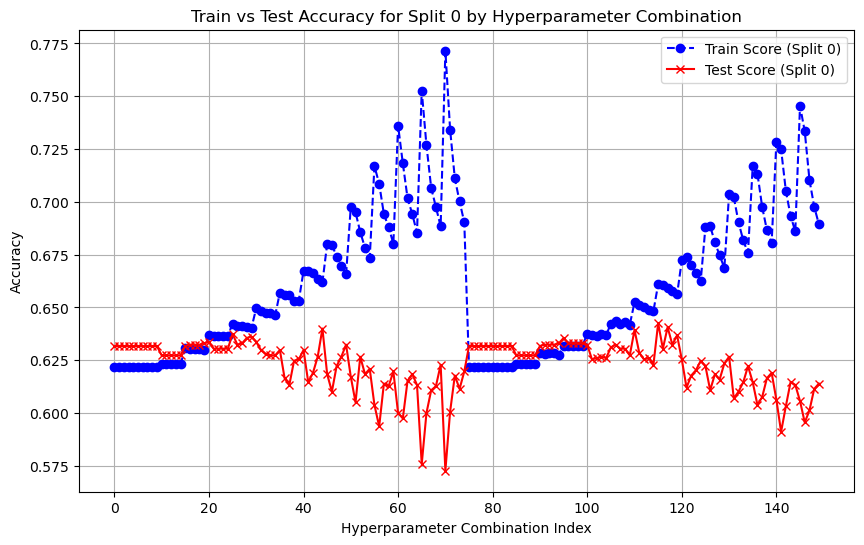

In [207]:
param_max_depth = results['param_max_depth']

# Use the index of hyperparameter combinations for plotting
param_index = range(len(train_result))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(param_index, train_result, label='Train Score (Split 0)', marker='o', linestyle='--', color='b')
plt.plot(param_index, test_result, label='Test Score (Split 0)', marker='x', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Split 0 by Hyperparameter Combination')
plt.legend()
plt.grid(True)
plt.show()

In [208]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}

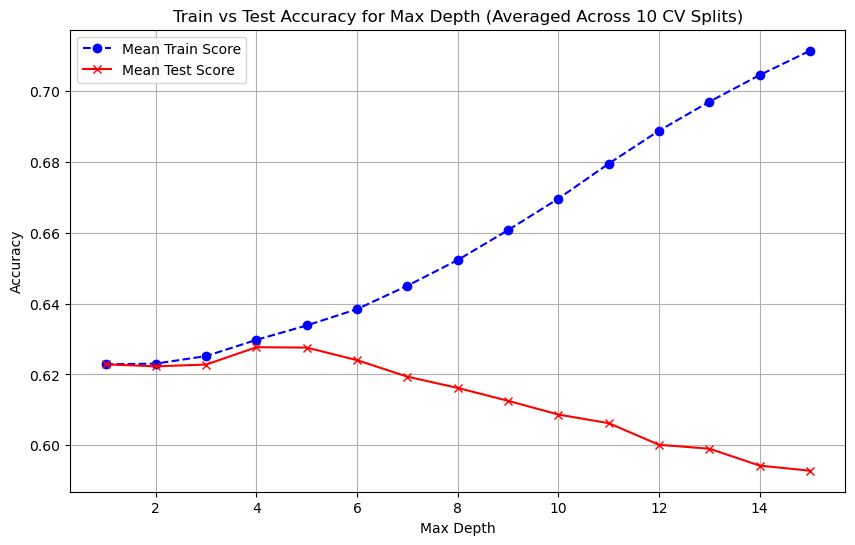

In [209]:
# Group results by max_depth to calculate mean test and train scores
mean_train_scores = results.groupby('param_max_depth')['mean_train_score'].mean()
mean_test_scores = results.groupby('param_max_depth')['mean_test_score'].mean()

# Plot the results for max_depth
plt.figure(figsize=(10, 6))
plt.plot(mean_train_scores.index, mean_train_scores, label='Mean Train Score', marker='o', linestyle='--', color='b')
plt.plot(mean_test_scores.index, mean_test_scores, label='Mean Test Score', marker='x', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Max Depth (Averaged Across 10 CV Splits)')
plt.legend()
plt.grid(True)
plt.show()

In [210]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}

In [211]:
best_params = grid_search.best_params_

In [212]:
best_model = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=rs  # Keep the random_state for reproducibility
)

In [213]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=1)

In [214]:
print(f'Training accuracy: {accuracy_score(y_train, best_model.predict(X_train)): .3f}')

Training accuracy:  0.632


In [215]:
print(f'Test accuracy: {accuracy_score(y_test, best_model.predict(X_test)): .3f}')

Test accuracy:  0.618


In [216]:
num_nodes = best_model.tree_.node_count
num_leaves = best_model.tree_.n_leaves

print(f'Total number of nodes: {num_nodes}')
print(f'Total number of leaves (rules): {num_leaves}')

Total number of nodes: 31
Total number of leaves (rules): 16


In [217]:
# classification report
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.73      0.67      2051
           1       0.63      0.49      0.55      1885

    accuracy                           0.62      3936
   macro avg       0.62      0.61      0.61      3936
weighted avg       0.62      0.62      0.61      3936



In [218]:
features = X.columns
# Get the feature index for the first split
first_split_feature_index = best_model.tree_.feature[0]

# Get the feature name by using the index
first_split_feature_name = features[first_split_feature_index]  

print(f'The first split is made on the feature: {first_split_feature_name}')

The first split is made on the feature: number_inpatient


In [219]:
importances = best_model.feature_importances_

In [220]:
feature_names = X.columns  # Names of the features
best_importances = best_model.feature_importances_  # Coefficients from the logistic regression model

# Combine feature names and coefficients into a readable format
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_importances
})

# Sort by the magnitude of importance
feature_importance['Importance'] = np.abs(feature_importance['Importance'])
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# View the top influential features
print(feature_importance.head(5))
    

             Feature  Importance
8   number_inpatient       0.791
5    num_medications       0.047
7   number_emergency       0.046
1                age       0.042
6  number_outpatient       0.020


In [221]:
from sklearn.metrics import roc_curve, roc_auc_score

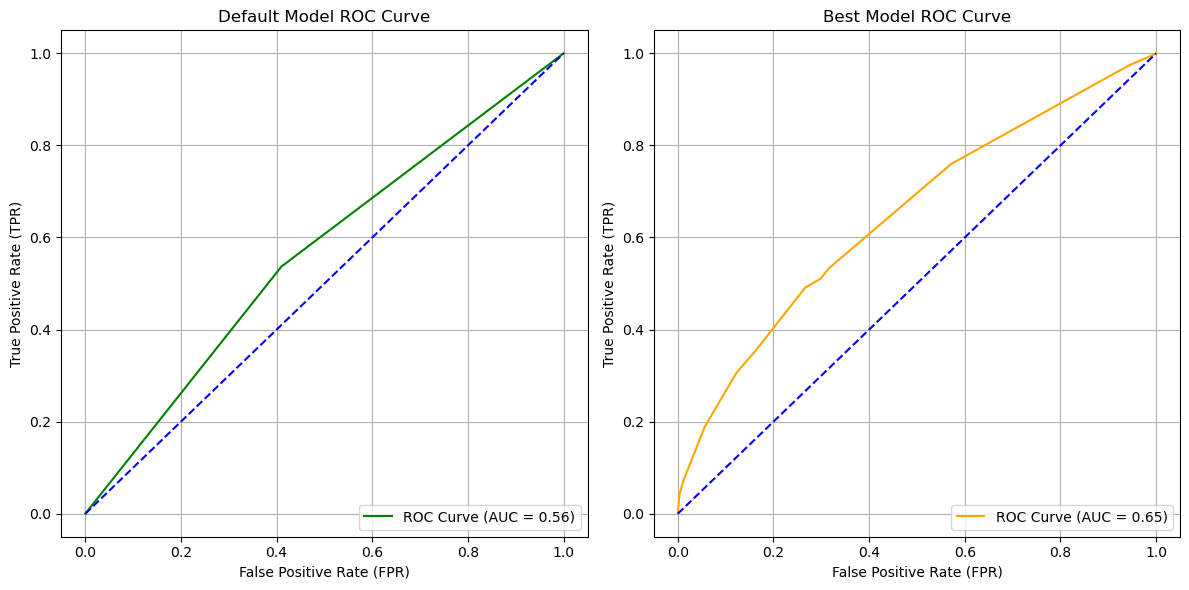

In [222]:
# Predicted probabilities for both models (for class 1)
y_proba_best = best_model.predict_proba(X_test)[:, 1]
y_proba_model = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for both models
fpr_model, tpr_model, thresholds_best = roc_curve(y_test, y_proba_model)
roc_auc_model = roc_auc_score(y_test, y_proba_model)

fpr_best, tpr_best, thresholds_model = roc_curve(y_test, y_proba_best)
roc_auc_best = roc_auc_score(y_test, y_proba_best)


# Create subplots for the two models
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot ROC for model (default model) at index 0
ax[0].plot(fpr_model, tpr_model, color='green', label=f'ROC Curve (AUC = {roc_auc_model:.2f})')
ax[0].plot([0, 1], [0, 1], color='blue', linestyle='--')
ax[0].set_xlabel('False Positive Rate (FPR)')
ax[0].set_ylabel('True Positive Rate (TPR)')
ax[0].set_title('Default Model ROC Curve')
ax[0].legend(loc='lower right')
ax[0].grid(True)

# Plot ROC for best_model at index 1
ax[1].plot(fpr_best, tpr_best, color='orange', label=f'ROC Curve (AUC = {roc_auc_best:.2f})')
ax[1].plot([0, 1], [0, 1], color='blue', linestyle='--')
ax[1].set_xlabel('False Positive Rate (FPR)')
ax[1].set_ylabel('True Positive Rate (TPR)')
ax[1].set_title('Best Model ROC Curve')
ax[1].legend(loc='lower right')
ax[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [223]:
_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=1)

### Summary characteristics of readmitted patients

In [224]:
X_test_df = pd.DataFrame(X_test, columns=features)[['number_inpatient', 'number_emergency', 'number_outpatient', 'num_medications', 'age']]

In [225]:
y_pred = best_model.predict(X_test)

In [226]:
X_test_df['predicted_readmitted'] = y_pred

In [227]:
predicted_readmitted = X_test_df[X_test_df['predicted_readmitted'] == 1]

In [228]:
X_test_df.age.value_counts().sort_index().index

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='age')

In [229]:
data['age'].value_counts().sort_index().index

Index(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'],
      dtype='object', name='age')

In [230]:
# Define bins and labels for each feature


inpatient_bins = [0, 1, 3, 5, 10, 100] 
inpatient_labels = ['0', '1-2', '3-5', '6-10', '10+']

medication_bins = [0, 5, 10, 20, 50, 100] 
medication_labels = ['0-5 meds', '6-10 meds', '11-20 meds', '21-50 meds', '50+ meds']

emergency_bins = [0, 1, 3, 5, 10, 100] 
emergency_labels = ['0', '1-2', '3-5', '6-10', '10+']

age_bins = [0,1,2,3,4,5,6,7,8,9,10] 
age_labels = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)']

outpatient_bins = [0, 1, 3, 5, 10, 100]
outpatient_labels = ['0', '1-2', '3-5', '6-10', '10+']

# Segment the data for each feature
predicted_readmitted.loc[:,'inpatient_group'] = pd.cut(predicted_readmitted['number_inpatient'], bins=inpatient_bins, labels=inpatient_labels)
predicted_readmitted.loc[:,'medication_group'] = pd.cut(predicted_readmitted['num_medications'], bins=medication_bins, labels=medication_labels)
predicted_readmitted.loc[:,'emergency_group'] = pd.cut(predicted_readmitted['number_emergency'], bins=emergency_bins, labels=emergency_labels)
predicted_readmitted.loc[:,'age_group'] = pd.cut(predicted_readmitted['age'], bins=age_bins, labels=age_labels)
predicted_readmitted.loc[:,'outpatient_group'] = pd.cut(predicted_readmitted['number_outpatient'], bins=outpatient_bins, labels=outpatient_labels)

# Display the distribution for each feature
inpatient_distribution = predicted_readmitted['inpatient_group'].value_counts(normalize=True)
medication_distribution = predicted_readmitted['medication_group'].value_counts(normalize=True)
emergency_distribution = predicted_readmitted['emergency_group'].value_counts(normalize=True)
age_distribution = predicted_readmitted['age_group'].value_counts(normalize=True)
outpatient_distribution = predicted_readmitted['outpatient_group'].value_counts(normalize=True)




C:\Users\JohnMarquess\AppData\Local\Temp\ipykernel_2592\1896330773.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_readmitted.loc[:,'inpatient_group'] = pd.cut(predicted_readmitted['number_inpatient'], bins=inpatient_bins, labels=inpatient_labels)
C:\Users\JohnMarquess\AppData\Local\Temp\ipykernel_2592\1896330773.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_readmitted.loc[:,'medication_group'] = pd.cut(predicted_readmitted['num_medications'], bins=medication_bins, labels=med

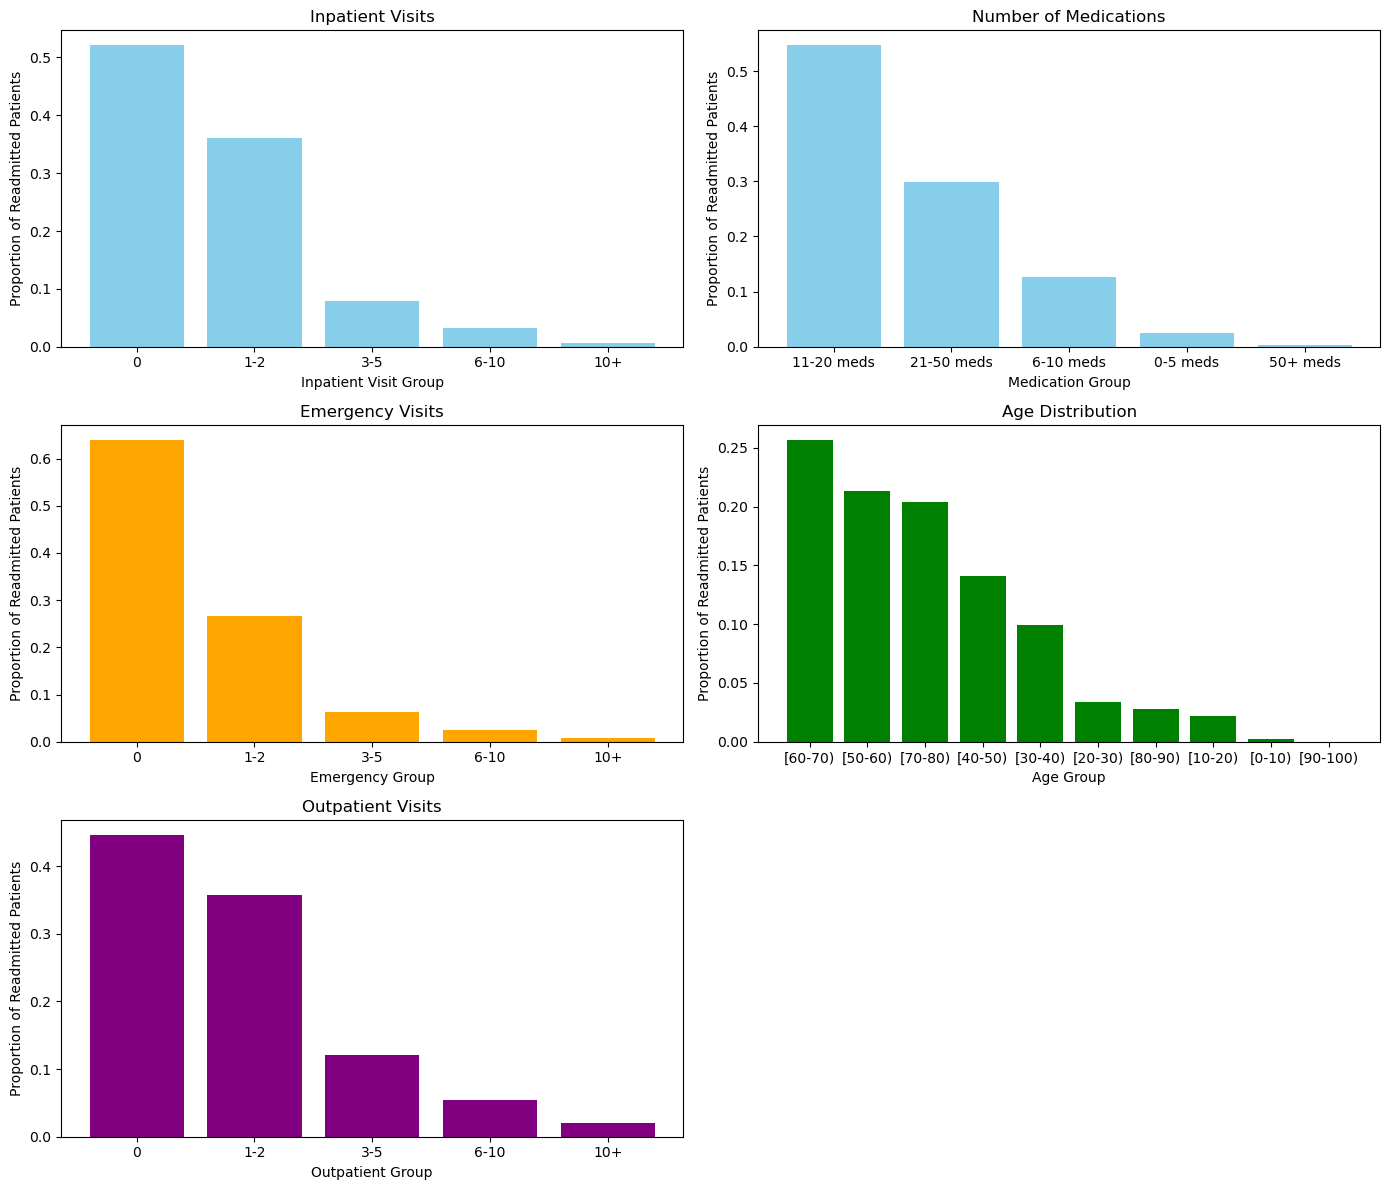

In [231]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Flatten the axes array for easier access
axes = axes.flatten()

# Plot for inpatient visits
axes[0].bar(inpatient_distribution.index, inpatient_distribution, color='skyblue')
axes[0].set_title('Inpatient Visits')
axes[0].set_xlabel('Inpatient Visit Group')
axes[0].set_ylabel('Proportion of Readmitted Patients')


# Plot for medications
axes[1].bar(medication_distribution.index, medication_distribution, color='skyblue')
axes[1].set_title('Number of Medications')
axes[1].set_xlabel('Medication Group')
axes[1].set_ylabel('Proportion of Readmitted Patients')


# Plot for emergency visits
axes[2].bar(emergency_distribution.index, emergency_distribution, color='orange')
axes[2].set_title('Emergency Visits')
axes[2].set_xlabel('Emergency Group')
axes[2].set_ylabel('Proportion of Readmitted Patients')


# Plot for age
axes[3].bar(age_distribution.index, age_distribution, color='green')
axes[3].set_title('Age Distribution')
axes[3].set_xlabel('Age Group')
axes[3].set_ylabel('Proportion of Readmitted Patients')


# Plot for outpatient visits
axes[4].bar(outpatient_distribution.index, outpatient_distribution, color='purple')
axes[4].set_title('Outpatient Visits')
axes[4].set_xlabel('Outpatient Group')
axes[4].set_ylabel('Proportion of Readmitted Patients')


# Turn off the last subplot (empty space in 3x2 layout)
axes[5].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


### Pickle the best model for future use

In [232]:
import pickle


# Save the best model
with open('data/DT.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)